### Activate the auto-reload

In [27]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Import the libraries

In [28]:
import sys
from pathlib import Path
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.metrics import silhouette_score
import plotly.graph_objects as go
import plotly.express as px

### Set file path to parent directory

In [29]:
sys.path.append(str(Path().resolve().parent / "src"))
os.chdir("../")

### Import the homemade functions

In [30]:
from src.data.data_import import DataImporter
from src.features.generate_features import GenerateFeatures

### Get the API keys to access UN data

How-to available at this address: [https://uncomtrade.org/docs/api-subscription-keys/](https://uncomtrade.org/docs/api-subscription-keys/)

In [31]:
UN_API_KEY = "<YOUR_API_KEY>"

# 1. Import the data

In [32]:
importer = DataImporter(api_key=UN_API_KEY)
df = importer.get_merged_data()
df.head(2)

Reading merged data from: /Users/lianyijing/Library/Mobile Documents/com~apple~CloudDocs/東大/2025 S/Data Science for Public Policy/graspp-25S-trade/data/interim/merge.csv


,,Export,Import,ILO
country,year,,,
ABW,2010,124523218.0,1.071034e+09,6.738
AFG,2014,570534007.0,7.697178e+09,1389.950


# 2. Generate the features

In [33]:
features_generator = GenerateFeatures(features="changepct", time_period="Y")
df_features = features_generator.transform(df)
df_drop = df_features.dropna()
df_Filter = df_drop.groupby('country').filter(lambda x: len(x) >= 5)
df_Filter.head(2)

/Users/lianyijing/Library/Mobile Documents/com~apple~CloudDocs/東大/2025 S/Data Science for Public Policy/graspp-25S-trade/src/features/generate_features.py:73: FutureWarning:

The default fill_method='ffill' in DataFrameGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.



Export        Import      ILO  Export_chpct1Y  \
country year                                                        
AGO     2009  4.063941e+10  2.391885e+10  432.430        2.066275   
        2011  6.642739e+10  2.079100e+10  540.716        0.634556   

              Import_chpct1Y  ILO_chpct1Y  
country year                               
AGO     2009        3.715792     0.063328  
        2011       -0.130770     0.250413

In [34]:
df_filter = df_Filter.reset_index()
df_filter.head(2)

,country,year,Export,Import,ILO,Export_chpct1Y,Import_chpct1Y,ILO_chpct1Y
0,AGO,2009,4.063941e+10,2.391885e+10,432.430,2.066275,3.715792,0.063328
1,AGO,2011,6.642739e+10,2.079100e+10,540.716,0.634556,-0.130770,0.250413


# 3. Descriptive statistics

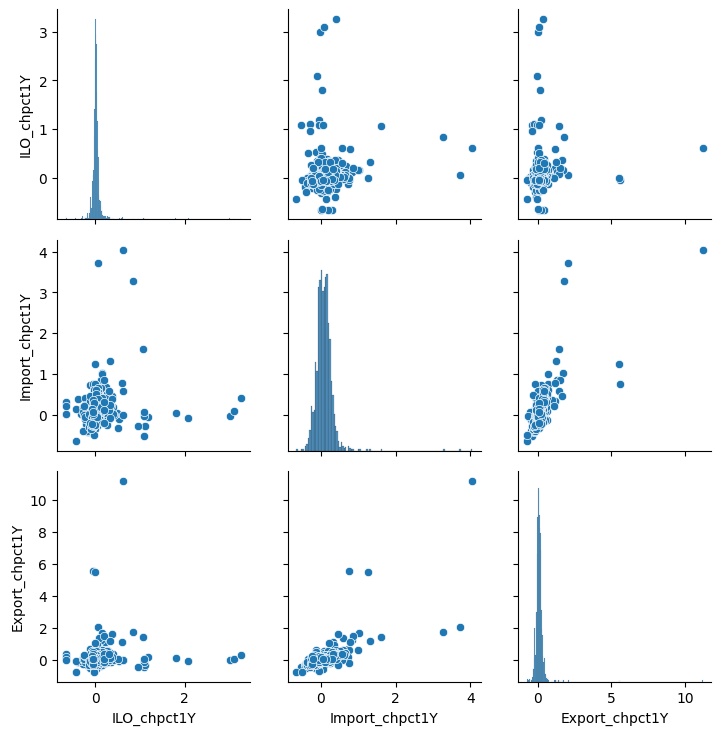

In [35]:
g = sns.PairGrid(df_filter.loc[:, ["ILO_chpct1Y", "Import_chpct1Y", "Export_chpct1Y"]])
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)

# 4. Cloud of Countries

In [36]:
# I ran regression on the import and export trade volume to get the trends of countries on export and import. 
# Then plot the points with coefficients of export (y-axis) and import (x-axis) to see the correlations.
# We can conduct case studies on the outlier countries

# Define a function to calculate the trend for each country
def calculate_trend(df, country):
    # Filter the data for the specified country
    country_df = df[df['country'] == country]
    
    # Sort the data by year
    country_df = country_df.sort_values('year')
    
    # Create a linear regression model
    model = LinearRegression()
    
    # Fit the model to the data
    model.fit(country_df[['Import_chpct1Y','Export_chpct1Y']], country_df['ILO_chpct1Y'])
    
    # Get the coefficient of the linear regression model
    trend = model.coef_
    
    return trend

# Calculate the trends for each country
trends = {}
for country in df_filter['country'].unique():
    trend = calculate_trend(df_filter, country)
    trends[country] = trend

# Create a DataFrame with the trends
trends_df = pd.DataFrame(list(trends.items()), columns=['country', 'trend'])

# Print the first few rows of the trends DataFrame
print(trends_df.head())

  country                                        trend
0     AGO    [-0.1685722765061743, 0.1496685842191645]
1     ALB    [0.1900519612037662, -0.2804923947433011]
2     ARE    [-2.3981020286968042, 3.4157996641049593]
3     ARG   [0.03950654903623499, 0.07474641699902464]
4     AUS  [0.09079259703754507, 0.012224001710847523]


In [37]:
# Create a DataFrame with the trends
trends_df = pd.DataFrame(list(trends.items()), columns=['country', 'trend'])

# Separate the coefficients into two columns
trends_df[['Import_Coefficient', 'Export_Coefficient']] = trends_df['trend'].apply(pd.Series)

# Drop the original 'trend' column
trends_df = trends_df.drop('trend', axis=1)

# Print the first few rows of the trends DataFrame
print(trends_df.head())

  country  Import_Coefficient  Export_Coefficient
0     AGO           -0.168572            0.149669
1     ALB            0.190052           -0.280492
2     ARE           -2.398102            3.415800
3     ARG            0.039507            0.074746
4     AUS            0.090793            0.012224


In [38]:
# Plot the DataFrame as a cloud of points
fig = px.scatter(trends_df, x='Import_Coefficient', y='Export_Coefficient', hover_name='country',
                 hover_data=['Import_Coefficient', 'Export_Coefficient'])

# Update the layout
fig.update_layout(
    title='Cloud of Points',
    xaxis_title='Import Coefficient',
    yaxis_title='Export Coefficient',
)

# Show the plot
fig.show()

In [39]:
# The result shows a negative correlation between export and import regression coefficients
# where countries with increasing import trends tend to have decreasing export trends, and vice versa

In [40]:
# Create a new column for the country codes
trends_df['country_code'] = trends_df['country'].apply(lambda x: x[:3])  

# Define the figure
fig = go.Figure(data=go.Choropleth(
    locations=trends_df['country_code'],  
    z=trends_df['Import_Coefficient'].astype(float),  
    text=trends_df['country'],  
    colorscale='Reds',  
    autocolorscale=False,
    reversescale=False,
    marker_line_color='darkgray',
    marker_line_width=0.5,
    colorbar_title='Import Coefficient',
))

fig.update_layout(
    title_text='Import Coefficients by Country',
    geo=dict(
        showframe=False,
        showcoastlines=False,
        projection_type='equirectangular',
    ),
)

fig.show()

# Create another figure for the export coefficients
fig_export = go.Figure(data=go.Choropleth(
    locations=trends_df['country_code'],  
    z=trends_df['Export_Coefficient'].astype(float), 
    text=trends_df['country'],  
    colorscale='Blues',  
    autocolorscale=False,
    reversescale=False,
    marker_line_color='darkgray',
    marker_line_width=0.5,
    colorbar_title='Export Coefficient',
))

fig_export.update_layout(
    title_text='Export Coefficients by Country',
    geo=dict(
        showframe=False,
        showcoastlines=False,
        projection_type='equirectangular',
    ),
)

# Show the plot
fig_export.show()